In [8]:
from PIL import Image

import torch
from torch import nn
from torchvision import transforms


### Horse2Zebra on Golden Retreiver

In [9]:
class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)

In [10]:
netG = ResNetGenerator()

weights = torch.load('../data/p1ch2/horse2zebra_0.4.0.pth')
netG.load_state_dict(weights)
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

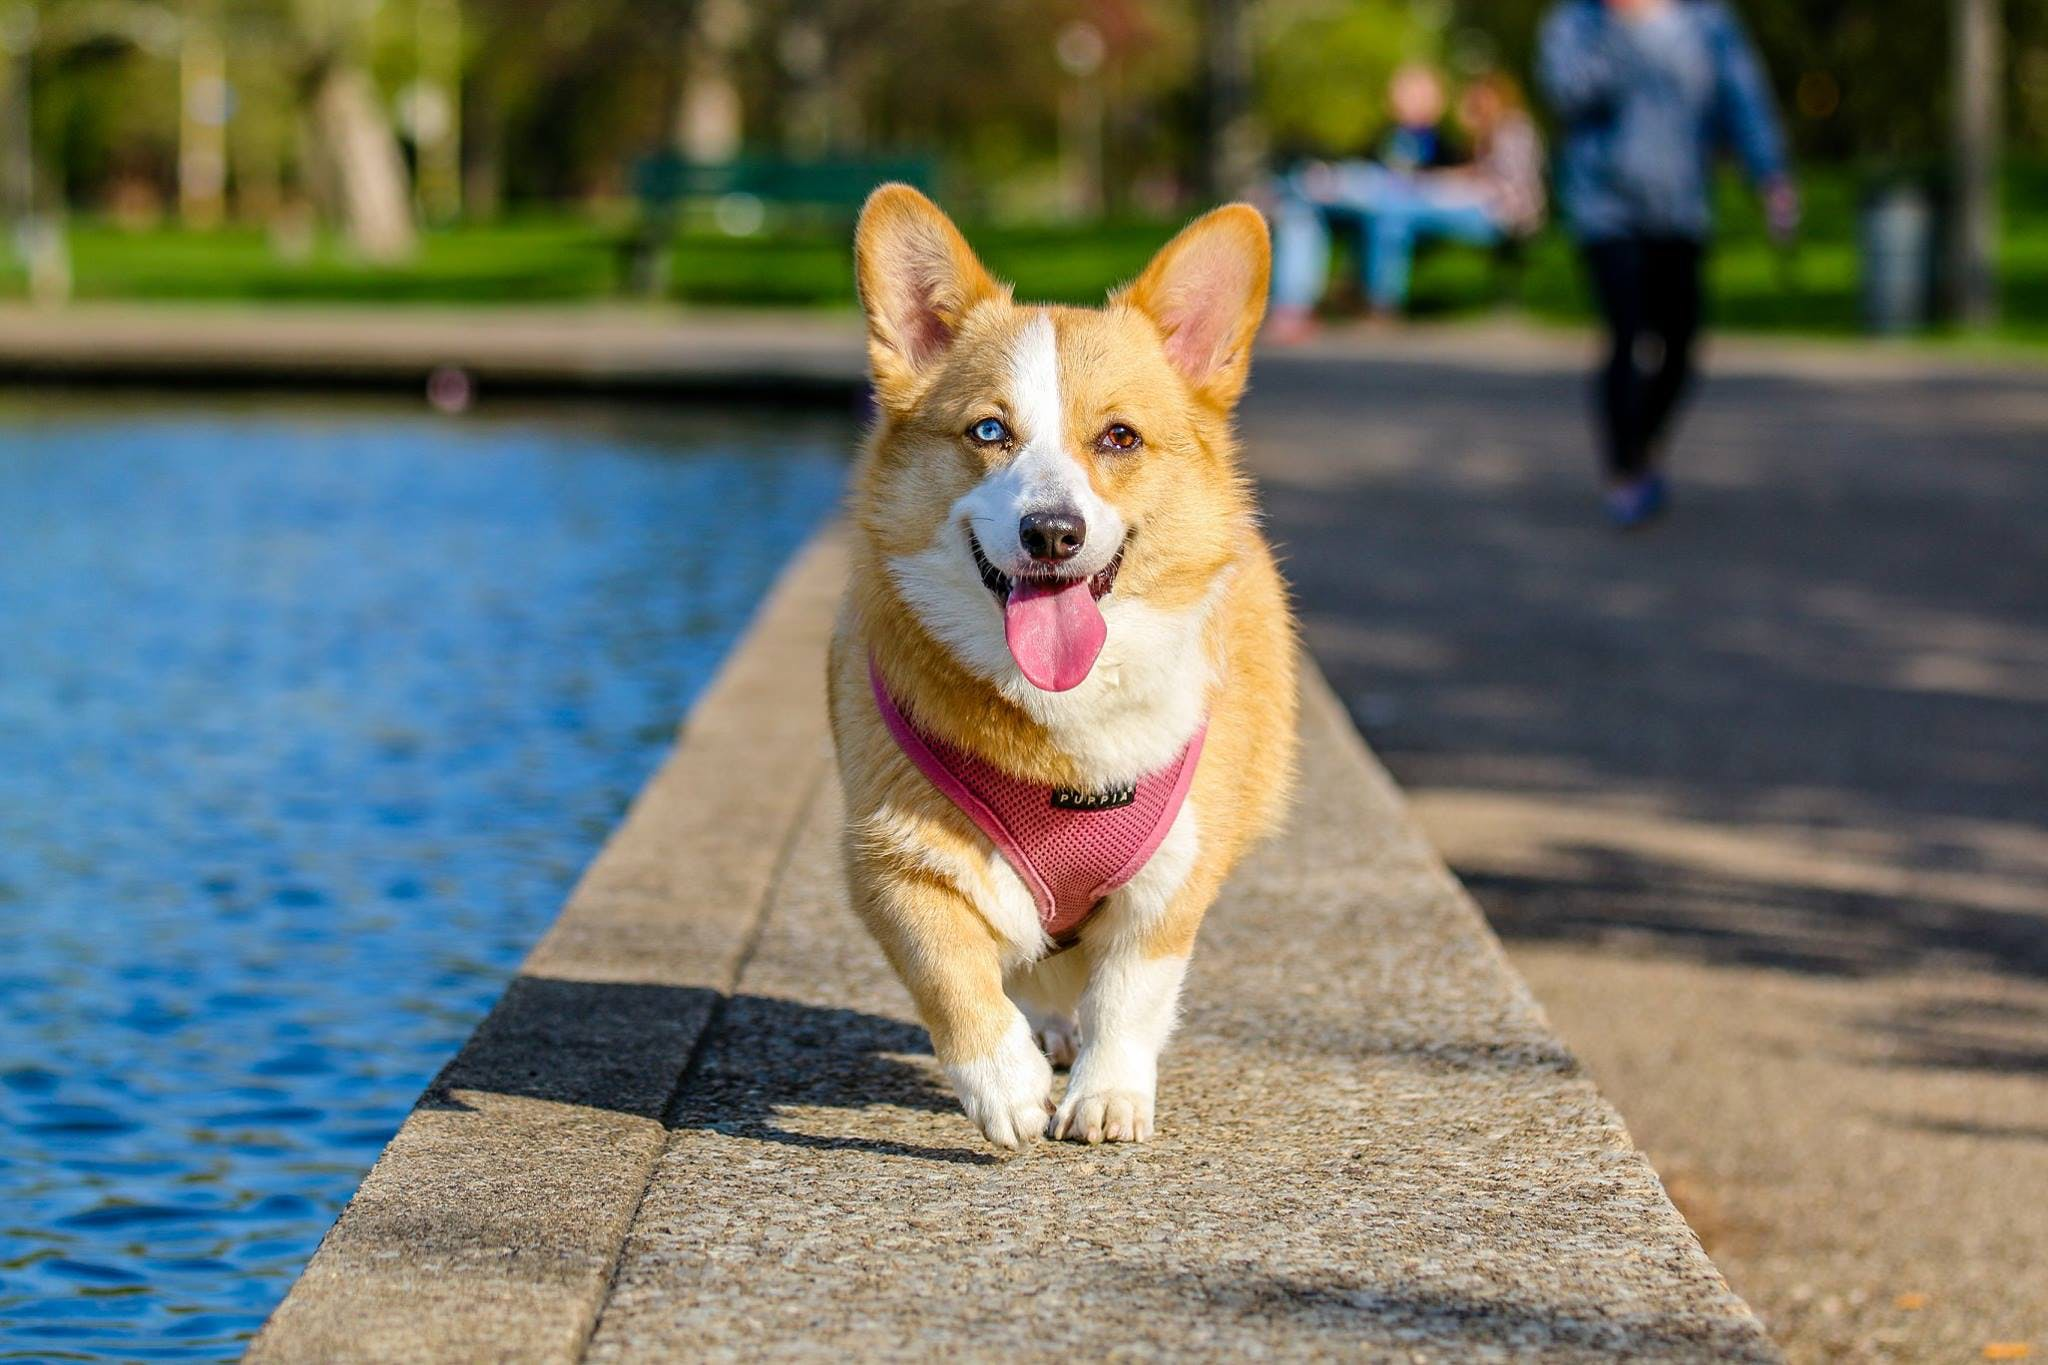

In [11]:
img = Image.open('../data/p1ch2/pexels-muhannad-alatawi-58997.jpg')
img

In [12]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, dim=0)

In [13]:
out = netG(batch_t)

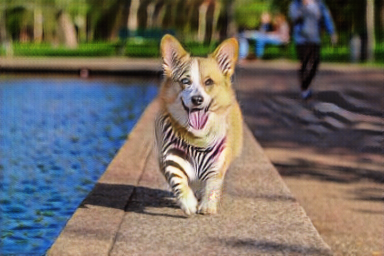

In [16]:
out_t = (out.squeeze() + 1.)/2.
out_image = transforms.ToPILImage()(out_t)
out_image

1. Feed the image of the golden retriever into the horse-to-zebra model.
    1. What do you need to do to the image to prepare it? <br>
        Just need a couple of transformations - first to resize the image and then turn it into the tensor.
    2. What does the output look like? <br>
        It's interesting to see that the network appies the zebra tranformation to parts of dog. Perhaps, it could resembe some parts of dog as furry animal.
        The rest of the part didn't get the zebra effect because of the pose of the dog?

### Github project with hubconf.py


2. Search GitHub for projects that provide a hubconf.py file.

    1.How many repositories are returned? <br>
        There are dozens of repos, if not more

    2. Find an interesting-looking project with a hubconf.py. Can you understand the purpose of the project from the documentation? <br>
        Like [this](https://github.com/asteroid-team/asteroid/blob/master/hubconf.py) one. <br>
        It's a audio separation toolkit so I guess it takes an input which has multiple audio (think background wind noise when someone's talking) and separates each audio from another. <br>
        It'd be cool to use this and maybe even turn it into a mobile app at some point for own use

    3. Bookmark the project, and come back after you’ve finished this book. Can you understand the implementation?
        Saved link above